### Our objective: robustify a given neural network 
0. Prepare for experiments (DONE)
1. Display the pattern how benign samples and adversarial samples being evalauted by PI (e.g., B->B->B->B, B->B->B->A). (DONE)
2. Identify the layer required further improvement (PENDING)
3. A. Robustify model (PENDING)
3. B. Store the robustified model (PENDING)
4. Evalaute effectiveness (whether robustified model truly enhance the robustness in terms of attack success rate Or PI indentification rate) (PENDING)

##### Sub tasks (compulsory functionalities to achieve above procedures 
1. Print out the distribution after robustifying (DONE)
2. Complete robustified CNN (PENDING)

In [1]:
'''
0. Prepare for experiments 
'''
%matplotlib inline
import property_inference_interface
PI = property_inference_interface.PropertyInferenceInterface()

meta_params = {
    'num_of_LPs': 4,
    'size_of_train_set': 2000,
    'size_of_test_set': 100,
    'flatten': True, 
    'model_type': 'FC',
    'adv_attack': 'i_FGSM'
}

PI.set_meta_params(meta_params)
PI.print_meta_params()
PI.prepare_dataset()
PI.print_dataset_shape()

num_of_LPs           : 4
size_of_train_set    : 2000
size_of_test_set     : 100
flatten              : True
model_type           : FC
adv_attack           : i_FGSM
Train dataset
(2000, 784) (2000,)
Test dataset
(100, 784) (100,)


In [2]:
'''
0. Prepare for experiments 
'''
# PI.generate_model(num_of_epochs=15)
# PI.store_model('MNIST_CNN.pt')
PI.load_model('MNIST_FC.pt')

print('Evaluate accurancy: original')
PI.eval_model('train', on_robustified_model=False)
PI.eval_model('test', on_robustified_model=False)

Evaluate accurancy: original
Model ( train ) accurancy: 0.9805
Model ( test ) accurancy: 0.99


//anaconda3/lib/python3.7/site-packages/torch/serialization.py:453: SourceChangeWarning: source code of class 'torch.nn.modules.linear.Linear' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
//anaconda3/lib/python3.7/site-packages/torch/serialization.py:453: SourceChangeWarning: source code of class 'torch.nn.modules.activation.ReLU' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


0.99

In [3]:
'''
0. Prepare for experiments 
'''
PI.generate_LPs()
(B_detect_ratio, A_detect_ratio), (B_LPs, A_LPs), (B_LPs_score, A_LPs_score) = PI.evaluate_algorithm_on_test_set(verbose=True)
print(B_detect_ratio, A_detect_ratio)

# B: Benign (normal) samples within test dataset 
# B2: Benign (normal) samples within train dataset 
# A: Adversarial samples based on benign samples within test dataset 

Benign input matching...
['benign', 'adversarial', 'benign', 'benign'] adversarial
Benign input matching...
['benign', 'benign', 'benign', 'benign'] benign
Benign input matching...
['benign', 'benign', 'benign', 'benign'] benign
Benign input matching...
['benign', 'benign', 'benign', 'benign'] benign
Benign input matching...
['benign', 'benign', 'benign', 'benign'] benign
Benign input matching...
['benign', 'benign', 'benign', 'benign'] benign
Benign input matching...
['benign', 'benign', 'benign', 'benign'] benign
Benign input matching...
['benign', 'benign', 'benign', 'benign'] benign
Benign input matching...
['adversarial', 'benign', 'benign', 'benign'] adversarial
Benign input matching...
['benign', 'benign', 'benign', 'benign'] benign
Benign input matching...
['benign', 'benign', 'benign', 'benign'] benign
Benign input matching...
['benign', 'benign', 'benign', 'benign'] benign
Benign input matching...
['benign', 'benign', 'benign', 'benign'] benign
Benign input matching...
['beni

Using TensorFlow backend.


Adversarial input matching...
['adversarial', 'adversarial', 'benign', 'benign'] adversarial
Adversarial input matching...
['adversarial', 'adversarial', 'benign', 'benign'] adversarial
Adversarial input matching...
['adversarial', 'adversarial', 'benign', 'benign'] adversarial
Adversarial input matching...
['adversarial', 'adversarial', 'benign', 'benign'] adversarial
Adversarial input matching...
['adversarial', 'adversarial', 'benign', 'benign'] adversarial
Adversarial input matching...
['adversarial', 'adversarial', 'benign', 'benign'] adversarial
Adversarial input matching...
['adversarial', 'adversarial', 'benign', 'benign'] adversarial
Adversarial input matching...
['adversarial', 'adversarial', 'benign', 'benign'] adversarial
Adversarial input matching...
['adversarial', 'adversarial', 'benign', 'benign'] adversarial
Adversarial input matching...
['adversarial', 'adversarial', 'adversarial', 'benign'] adversarial
Adversarial input matching...
['adversarial', 'adversarial', 'adv

(99, 4) (49, 4)
This indicates the portion of inputs to be judged as "benign"
[0.91919192 0.92929293 0.96969697 0.97979798] test dataset (benign)
[0.08163265 0.06122449 0.89795918 0.95918367] test dataset (adversarial)


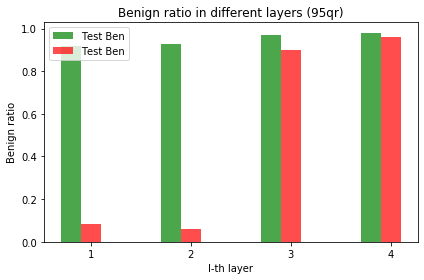

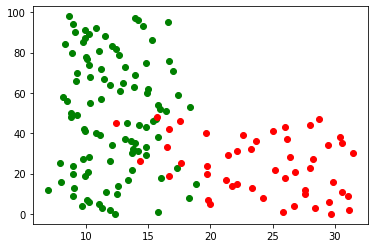

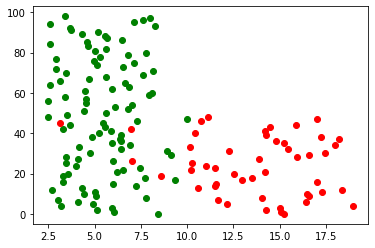

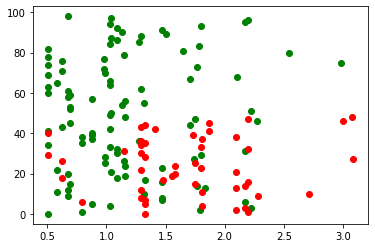

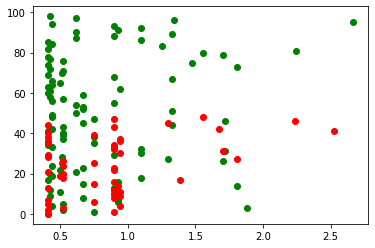

In [4]:
'''
1. Display the pattern how benign samples and adversarial samples being evalauted by PI (e.g., B->B->B->B, B->B->B->A).
'''
import matplotlib.pyplot as plt
import numpy as np

qr = '95'
BLPs, ALPs = np.array(B_LPs), np.array(A_LPs) 
print(BLPs.shape, ALPs.shape)

BLPs[BLPs=='benign'] = 1
BLPs[BLPs=='adversarial'] = 0
BLPs = BLPs.astype(np.int)
prob_BLPs = np.sum(BLPs, axis=0) / BLPs.shape[0]

ALPs[ALPs=='benign'] = 1
ALPs[ALPs=='adversarial'] = 0
ALPs = ALPs.astype(np.int)
prob_ALPs = np.sum(ALPs, axis=0) / ALPs.shape[0]

print('This indicates the portion of inputs to be judged as "benign"')
print(prob_BLPs, 'test dataset (benign)')
print(prob_ALPs, 'test dataset (adversarial)')

# create plot
fig, ax = plt.subplots()
num_of_layers = 4
index = np.arange(num_of_layers)
bar_width, opacity = 0.2, 0.7

rects1 = plt.bar(index, prob_BLPs, bar_width, alpha=opacity, color='g', label='Test Ben')
rects2 = plt.bar(index + bar_width, prob_ALPs, bar_width, alpha=opacity, color='r', label='Test Ben')

plt.xlabel('I-th layer')
plt.ylabel('Benign ratio')
plt.title('Benign ratio in different layers ('+qr+'qr)')
plt.xticks(index + bar_width, ('1', '2', '3', '4'))
plt.legend()

plt.tight_layout()
plt.show()

B_LPs_score, A_LPs_score = np.array(B_LPs_score), np.array(A_LPs_score)
for i in range(B_LPs_score.shape[1]):
    B_score, A_score = B_LPs_score[:,i], A_LPs_score[:, i]
    B_indices, A_indices = np.arange(B_score.shape[0]), np.arange(A_score.shape[0])
    plt.plot(B_score, B_indices, 'go')
    plt.plot(A_score, A_indices, 'ro')
    plt.show()

In [5]:
'''
2. Identify the layer required further improvement (PENDING)
'''
# func (for automatically locate which layer should be further improved)

'\n2. Identify the layer required further improvement (PENDING)\n'

In [6]:
'''
3. Robustify model 
let's say it's the 3rd layer 
'''

PI.generate_robustified_model('FC', 30)

print('Evaluate accurancy: original')
PI.eval_model('train', on_robustified_model=False)
PI.eval_model('test', on_robustified_model=False)
print('Evaluate accurancy: robustified')
PI.eval_model('train', on_robustified_model=True)
PI.eval_model('test', on_robustified_model=True)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
Evaluate accurancy: original
Model ( train ) accurancy: 0.9805
Model ( test ) accurancy: 0.99
Evaluate accurancy: robustified
Model ( train ) accurancy: 0.97
Model ( test ) accurancy: 0.94


0.94

0.8478260869565217 0.5957446808510638
(92, 4) (94, 4)
This indicates the portion of inputs to be judged as "benign"
[0.91304348 0.94565217 0.92391304 0.90217391] test dataset (benign)
[0.79787234 0.57446809 0.61702128 0.71276596] test dataset (adversarial)


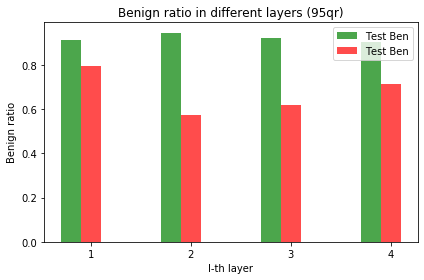

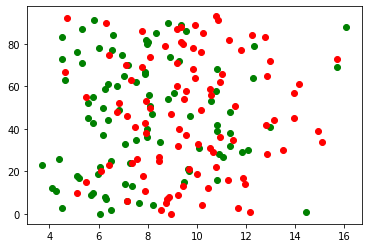

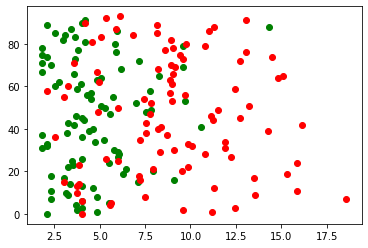

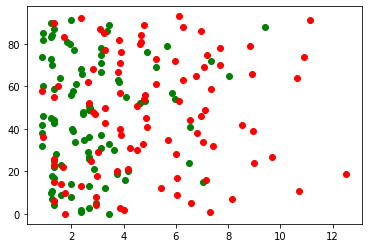

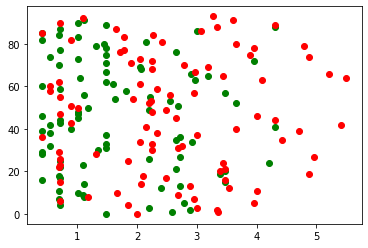

In [7]:
import copy
PI.model = copy.deepcopy(PI.robustified_model)

PI.generate_LPs()
(B_detect_ratio, A_detect_ratio), (B_LPs, A_LPs), (B_LPs_score, A_LPs_score) = PI.evaluate_algorithm_on_test_set(verbose=False)
print(B_detect_ratio, A_detect_ratio)

import matplotlib.pyplot as plt
import numpy as np

qr = '95'
BLPs, ALPs = np.array(B_LPs), np.array(A_LPs) 
print(BLPs.shape, ALPs.shape)

BLPs[BLPs=='benign'] = 1
BLPs[BLPs=='adversarial'] = 0
BLPs = BLPs.astype(np.int)
prob_BLPs = np.sum(BLPs, axis=0) / BLPs.shape[0]

ALPs[ALPs=='benign'] = 1
ALPs[ALPs=='adversarial'] = 0
ALPs = ALPs.astype(np.int)
prob_ALPs = np.sum(ALPs, axis=0) / ALPs.shape[0]

print('This indicates the portion of inputs to be judged as "benign"')
print(prob_BLPs, 'test dataset (benign)')
print(prob_ALPs, 'test dataset (adversarial)')

# create plot
fig, ax = plt.subplots()
num_of_layers = 4
index = np.arange(num_of_layers)
bar_width, opacity = 0.2, 0.7

rects1 = plt.bar(index, prob_BLPs, bar_width, alpha=opacity, color='g', label='Test Ben')
rects2 = plt.bar(index + bar_width, prob_ALPs, bar_width, alpha=opacity, color='r', label='Test Ben')

plt.xlabel('I-th layer')
plt.ylabel('Benign ratio')
plt.title('Benign ratio in different layers ('+qr+'qr)')
plt.xticks(index + bar_width, ('1', '2', '3', '4'))
plt.legend()

plt.tight_layout()
plt.show()

B_LPs_score, A_LPs_score = np.array(B_LPs_score), np.array(A_LPs_score)
for i in range(B_LPs_score.shape[1]):
    B_score, A_score = B_LPs_score[:,i], A_LPs_score[:, i]
    B_indices, A_indices = np.arange(B_score.shape[0]), np.arange(A_score.shape[0])
    plt.plot(B_score, B_indices, 'go')
    plt.plot(A_score, A_indices, 'ro')
    plt.show()